In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import lightgbm as lgb
import shap

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)

sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%matplotlib inline

# Load & Split Data

In [2]:
# Read data
data = pd.read_pickle('20231108_Dataset_Processed.pkl')
data.head()

,transformer_load,radiation,windspeed_10m,windspeed_100m,windspeed_squall,nedu_e1a,nedu_e1b,nedu_e1c,nedu_e2a,nedu_e2b,...,day_of_year_cos,transformer_load_lag_2days,transformer_load_lag_5days,transformer_load_lag_7days,windspeed_100m_3h_mean,windspeed_100m_1d_mean,windspeed_squall_3h_mean,windspeed_squall_1d_mean,radiation_3h_mean,radiation_1d_mean
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-09 10:15:00+00:00,0.655497,2.139711e+06,6.068184,7.706377,10.432041,0.000022,0.000016,0.000012,0.000030,0.000026,...,-0.133015,0.860733,0.149738,0.314834,7.856740,8.482728,10.248645,8.407537,1.700433e+06,780098.818258
2021-04-09 10:30:00+00:00,0.676091,2.240682e+06,6.103702,7.747967,10.514462,0.000022,0.000015,0.000011,0.000030,0.000025,...,-0.133015,0.897033,0.159860,0.455148,7.846817,8.470331,10.310933,8.393179,1.777003e+06,782144.193583
2021-04-09 10:45:00+00:00,0.660384,2.341653e+06,6.141287,7.791777,10.601013,0.000021,0.000014,0.000011,0.000029,0.000024,...,-0.133015,0.907155,0.178360,0.492845,7.834948,8.457775,10.364110,8.378342,1.853714e+06,783613.980855
2021-04-09 11:00:00+00:00,0.660035,2.442624e+06,6.180901,7.837771,10.691594,0.000020,0.000013,0.000010,0.000029,0.000024,...,-0.133015,0.932984,0.172775,0.479581,7.819994,8.445067,10.406397,8.363042,1.930565e+06,784508.180074
2021-04-09 11:15:00+00:00,0.687260,2.466027e+06,6.159403,7.807181,10.734140,0.000019,0.000012,0.000009,0.000029,0.000024,...,-0.133015,0.929145,0.180803,0.512740,7.805399,8.434417,10.449004,8.348299,2.006537e+06,785131.799703


In [3]:
# Splitting the dataset into train, validation, and test sets
train_size = 0.75
val_size = 0.15
test_size = 0.10

# First split to separate out the test set
train_val, test = train_test_split(data, test_size=test_size, shuffle=False)

# Second split to separate out the validation set
train, val = train_test_split(train_val, test_size=test_size/(train_size + val_size), shuffle=False)

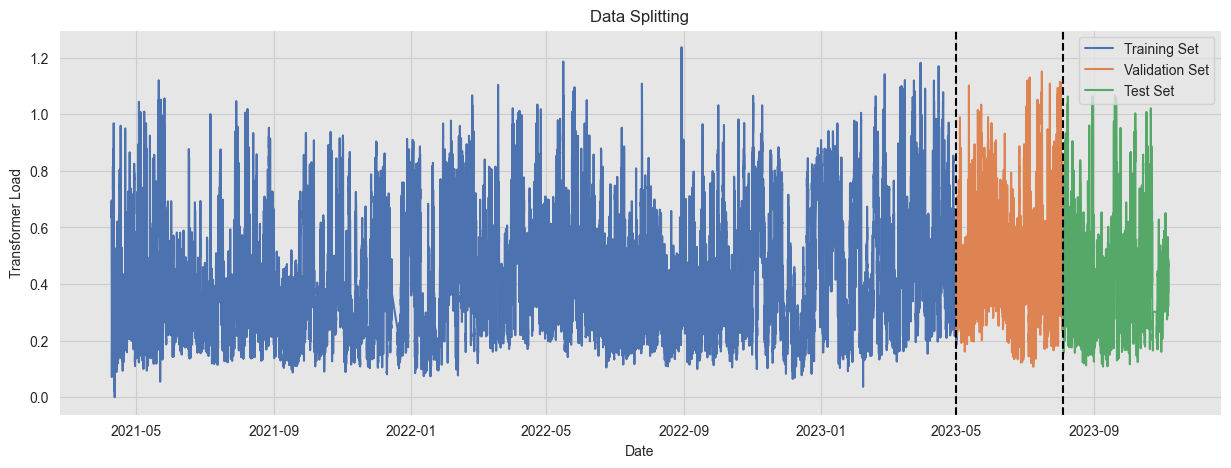

In [4]:
fig, ax = plt.subplots()

# Plotting the data
sns.lineplot(data=train['transformer_load'], ax=ax, label='Training Set', color=sns_c[0])
sns.lineplot(data=val['transformer_load'], ax=ax, label='Validation Set', color=sns_c[1])
sns.lineplot(data=test['transformer_load'], ax=ax, label='Test Set', color=sns_c[2])

# Adding vertical lines for the start of validation and test sets
ax.axvline(val.index[0], color='black', ls='--')
ax.axvline(test.index[0], color='black', ls='--')

# Setting up the legend and titles
ax.legend()
plt.title('Data Splitting')
plt.xlabel('Date')
plt.ylabel('Transformer Load')
plt.show()

In [5]:
# Preparing the data for LightGBM
target = 'transformer_load'
train_data = lgb.Dataset(train.drop(columns=target), label=train[target])
val_data = lgb.Dataset(val.drop(columns=target), label=val[target])
test_data = lgb.Dataset(test.drop(columns=target), label=test[target])

# Train Baseline Model

In [6]:
# Initial hyperparameters
lgb_params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'seed': 42,
    'learning_rate': 0.1,
    'num_leaves': 16,
    'max_depth': -1,
    'min_gain_to_split': 0,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'lambda_l1': 0.01,
    'lambda_l2': 0.01,
    'force_col_wise': 'true'
}

In [7]:
# Training models for each quantile
quantiles = [0.05, 0.5, 0.95]
models = {}

for quantile in quantiles:
    print(f"Training model for quantile: {quantile}")
    lgb_params['alpha'] = quantile
    model = lgb.train(lgb_params,
                      train_data, 
                      num_boost_round=400,
                      valid_sets=[train_data, val_data], 
                      callbacks=[lgb.early_stopping(stopping_rounds=40)]
                      )
    models[quantile] = model

Training model for quantile: 0.05
[LightGBM] [Info] Total Bins 6536
[LightGBM] [Info] Number of data points in the train set: 71560, number of used features: 30
[LightGBM] [Info] Start training from score 0.161955
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[271]	training's quantile: 0.00579618	valid_1's quantile: 0.00817148
Training model for quantile: 0.5
[LightGBM] [Info] Total Bins 6536
[LightGBM] [Info] Number of data points in the train set: 71560, number of used features: 30
[LightGBM] [Info] Start training from score 0.354974
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[192]	training's quantile: 0.0234456	valid_1's quantile: 0.0289382
Training model for quantile: 0.95
[LightGBM] [Info] Total Bins 6536
[LightGBM] [Info] Number of data points in the train set: 71560, number of used features: 30
[LightGBM] [Info] Start training from score 0.821640
Training until validation score

# Explainability Analysis

In [8]:
# Determine SHAP values 
explainer = shap.TreeExplainer(models[0.5])
shap_values = explainer.shap_values(train.drop(columns=['transformer_load']))

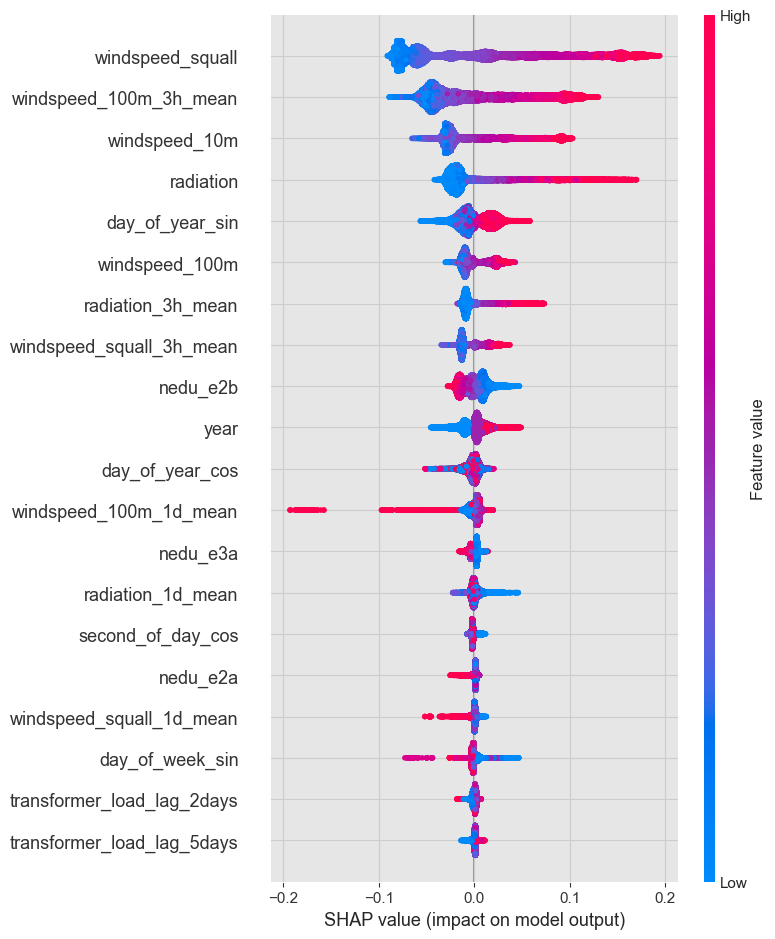

In [9]:
# Create the SHAP summary plot
shap.summary_plot(shap_values, train.drop(columns=['transformer_load']))

In summary, wind speed is a key driver of the model's predictions, with features such as 'windspeed_squall', 'windspeed_100m_3h_mean', and 'windspeed_10m' being the most influential. Additionally, radiation stands out as another critical factor. It's evident from the positive SHAP values and high feature values that increased readings of these wind speed and radiation features tend to elevate the predicted outcome. **This indicates that the model associates stronger wind conditions and higher radiation levels with a higher transformer load.** This makes sense, as wind and solar power are both renewable energy sources that supply more power when conditions are favorable (e.g. higher radiation and wind speed).

# Error Anylysis
We can see that from the metric scores and the visualizations, the model generalizes well on the validation data, but the performance drops on the test data. This makes sense as the time series data is highly dynamic and underlying patterns can change quickly.  

In [10]:
# Making predictions on the train, validation, and test sets for upper, median, and lower quantiles
train_preds_lower = models[0.05].predict(train.drop(columns=['transformer_load']))
train_preds = models[0.5].predict(train.drop(columns=['transformer_load']))
train_preds_upper = models[0.95].predict(train.drop(columns=['transformer_load']))

val_preds_lower = models[0.05].predict(val.drop(columns=['transformer_load']))
val_preds = models[0.5].predict(val.drop(columns=['transformer_load']))
val_preds_upper = models[0.95].predict(val.drop(columns=['transformer_load']))

test_preds_lower = models[0.05].predict(test.drop(columns=['transformer_load']))
test_preds = models[0.5].predict(test.drop(columns=['transformer_load']))
test_preds_upper = models[0.95].predict(test.drop(columns=['transformer_load']))

In [11]:
# Calculating MAE, RMSE, MAPE, MASE, and mdRAE
metrics = {}
for split, actual, predicted in [('Train', train['transformer_load'], train_preds),
                                 ('Validation', val['transformer_load'], val_preds),
                                 ('Test', test['transformer_load'], test_preds)]:
    
    r2 = r2_score(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    metrics[split] = [r2, mae, rmse]

In [12]:
# Converting the metrics to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics, index=['R2', 'MAE', 'RMSE']).T
metrics_df.rename_axis('Split', inplace=True)
metrics_df.reset_index(inplace=True)
metrics_df['Model'] = 'Baseline'
metrics_df.set_index(['Model', 'Split'], inplace=True)

metrics_df

R2       MAE      RMSE
Model    Split                                   
Baseline Train       0.884700  0.046891  0.071041
         Validation  0.846236  0.057876  0.081931
         Test        0.652971  0.073433  0.107015

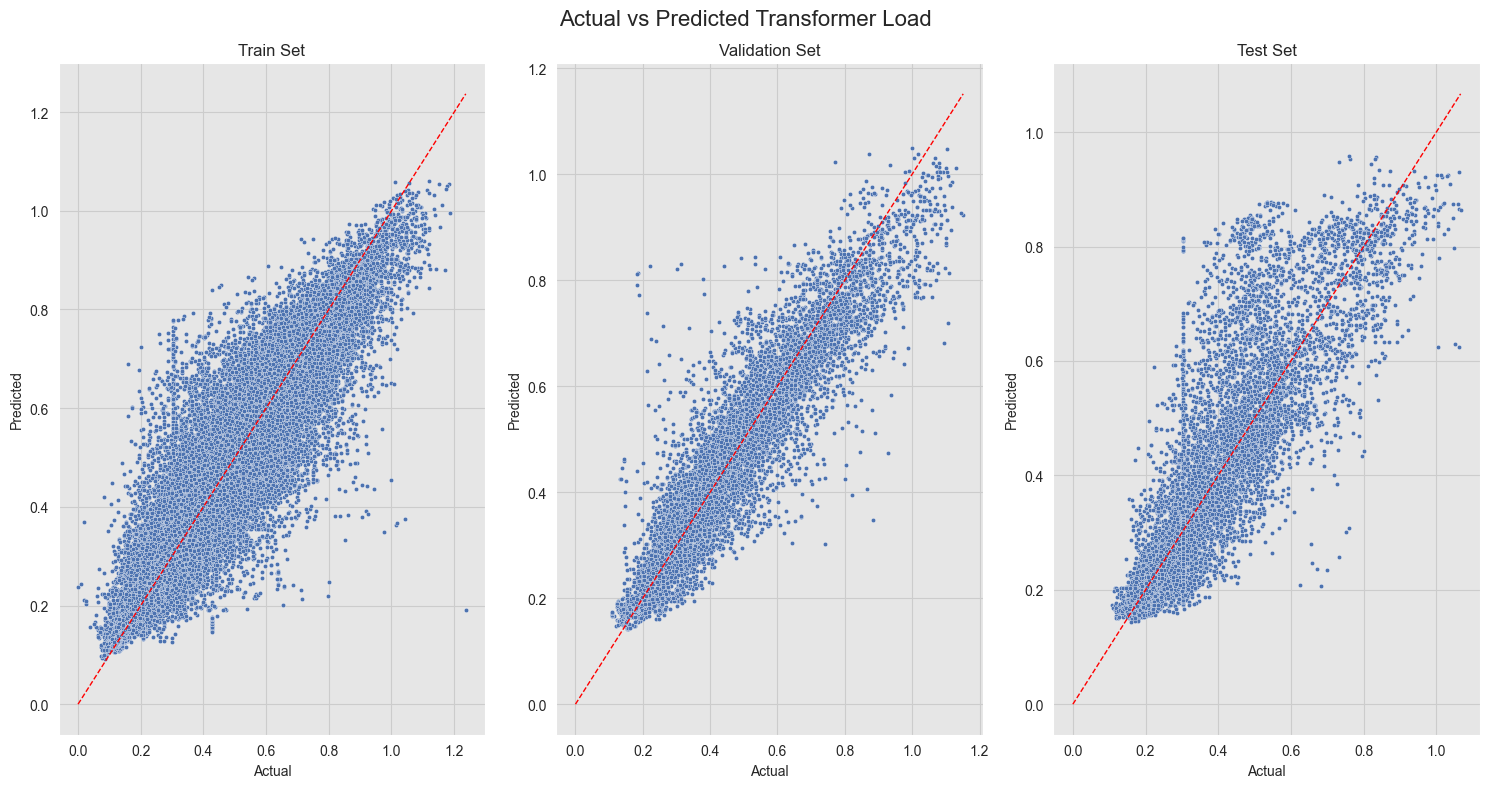

In [13]:
def plot_actual_vs_predicted(datasets, predictions, titles, x_label='Actual', y_label='Predicted'):
    """
    Plots actual values against predictions with ideal diagonal lines for each dataset.

    :param datasets: List of datasets containing the actual values.
    :param predictions: List of predictions corresponding to each dataset.
    :param titles: List of titles for each subplot.
    :param x_label: Label for the x-axis.
    :param y_label: Label for the y-axis.
    """
    # Number of datasets
    n_datasets = len(datasets)

    # Setting up the plot
    fig, axes = plt.subplots(nrows=1, ncols=n_datasets, figsize=(5 * n_datasets, 8))

    # Looping through datasets and predictions to create each subplot
    for i in range(n_datasets):
        sns.scatterplot(x=datasets[i]['transformer_load'], y=predictions[i], ax=axes[i], s=10)
        
        # Adding an ideal (diagonal) line
        max_val = max(datasets[i]['transformer_load'].max(), max(predictions[i]))
        axes[i].plot([0, max_val], [0, max_val], color='red', lw=1, linestyle='--')

        # Adding titles and labels
        axes[i].set_title(titles[i])
        axes[i].set_xlabel(x_label)
        axes[i].set_ylabel(y_label)
    
    fig.suptitle("Actual vs Predicted Transformer Load", fontsize=16)
    plt.tight_layout()

# Example usage for train, val, and test sets
plot_actual_vs_predicted(
    [train, val, test], 
    [train_preds, val_preds, test_preds], 
    ["Train Set", "Validation Set", "Test Set"]
)

Text(0.5, 1.0, 'Error Distribution Across Train, Validation, and Test Sets')

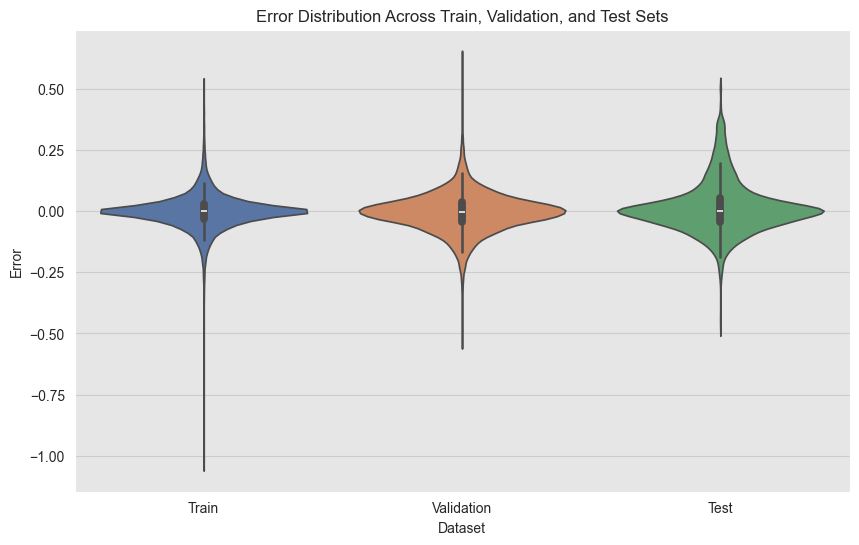

In [14]:
def calculate_errors(dataset, predictions):
    """
    Calculates errors between the actual values and predictions.
    :param dataset: The dataset containing the actual values.
    :param predictions: The predicted values.
    :return: A Series containing the errors.
    """
    return predictions - dataset['transformer_load']

# Calculating errors for each dataset
train_errors = calculate_errors(train, train_preds)
val_errors = calculate_errors(val, val_preds)
test_errors = calculate_errors(test, test_preds)

# Creating a DataFrame for plotting
error_data = pd.DataFrame({
    'Error': pd.concat([train_errors, val_errors, test_errors]),
    'Dataset': ['Train'] * len(train_errors) + ['Validation'] * len(val_errors) + ['Test'] * len(test_errors)
})

# Plotting errors using seaborn's violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Dataset', y='Error', data=error_data, hue='Dataset')
plt.title('Error Distribution Across Train, Validation, and Test Sets')

In [15]:
def plot_predictions_with_confidence_interval(dataset, preds_lower, preds, preds_upper, title):
    """
    Plots the real transformer_load vs predicted transformer_load with 90% confidence interval.

    :param dataset: The dataset containing the real transformer_load.
    :param preds_lower: Predictions for the lower bound (5th percentile).
    :param preds: Median predictions (50th percentile).
    :param preds_upper: Predictions for the upper bound (95th percentile).
    :param title: Title of the plot.
    """
    # Creating a Plotly figure
    fig = go.Figure()

    # Adding the real transformer load
    fig.add_trace(go.Scatter(
        x=dataset.index, y=dataset['transformer_load'], 
        mode='lines', name='Actual', 
        line=dict(color='blue')
    ))

    # Adding the predicted transformer load
    fig.add_trace(go.Scatter(
        x=dataset.index, y=preds, 
        mode='lines', name='Predicted', 
        line=dict(color='red')
    ))

    # Adding the lower bound of the confidence interval
    fig.add_trace(go.Scatter(
        x=dataset.index, y=preds_lower, 
        mode='lines', line=dict(width=0), 
        showlegend=False
    ))

    # Adding the upper bound of the confidence interval and filling the area
    fig.add_trace(go.Scatter(
        x=dataset.index, y=preds_upper, 
        mode='lines', line=dict(width=0), 
        fill='tonexty', fillcolor='rgba(255, 0, 0, 0.2)', 
        name='90% confidence interval'
    ))

    # Adding layout specifications
    fig.update_layout(
        title={
            'text': f'<b>{title}<b>',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 20, 'color': 'black', 'family': "Arial, sans-serif"}
        },
 
        xaxis_title='Date',
        yaxis_title='Transformer Load',
        hovermode="x unified"
    )

    return fig

In [16]:
days_15 = 15 * 96
plot_predictions_with_confidence_interval(
    test[0:days_15], 
    test_preds_lower[0:days_15],
    test_preds[0:days_15], 
    test_preds_upper[0:days_15], 
    "Short-term Forecasting of Transformer Load (1st 15 Days of Test Set)"
)

The model performs well on the first part of the test data as the predictions follow the same pattern as the actual values. The confidence interval is generally narrow, which means that the model is confident in its predictions, but also covers whenever the median model is wrong.

In [17]:
plot_predictions_with_confidence_interval(
    test[-days_15:-1], 
    test_preds_lower[-days_15:-1],
    test_preds[-days_15:-1], 
    test_preds_upper[-days_15:-1], 
    "Short-term Forecasting of Transformer Load (Last 15 Days of Test Set)"
)

The model performs poorly on the last part of the test data and the model is likely drifting. We can also see that the confidence interval have become wider, which means that the model is not confident in its predictions (as indicated by a lower R2 score as well).

# Support Decision Making to Prevent Congestion
We can now aid operators in making informed decisions to manage the grid efficiently and prevent congestion. With the quantile regression model, we can predict the load of a transformer with a certain probability and whenever the prediction exceeds the transformer's capacity of 1, the operator should take action to prevent this from happening. The following actions can be taken:

1. The operator can store the energy in batteries if the load is predicted slightly above the capacity.
2. Sell the energy to other regions (GOPACS) is the load is predicted to be much higher than the capacity.
3. Shutdown the wind turbines and solar panels when we can't sell the energy to other regions.


# Conclusions & Next Steps
- **Quantile Regression** is a good approach to model time series data as it can capture the **certainty of the predictions** compared to only single output regressionthat is hard to comprehend. 
- The **model's behavior is consistent with the domain knowledge** as it uses wind and radiation features to predict the transformer load.
- The model didn't overfitted but is likely **susceptible to drift**. It is highly recommended to retrain the model periodically to avoid this.
- It might be worthwhile to do some additional **hyperparameter tuning & automatic feature selections** methods to improve the model performance.
- At this point we are **unable to predict the future**. This would be possible if we only use features that are available at the time of prediction (e.g. derived, lagged and windowed features). This would be a good next step to do the actual forecasting.
- It would also be a good idea try other models that can direcly predict future values such as **statiscal models** (e.g. ARIMA, SARIMA, etc.) and **neural networks** (e.g. LSTM, Transformers, etc.). An hybrid approach would be most feasible to balance the performance and interpretability.